In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro 
from numpyro.infer import NUTS, MCMC
import pandas as pd
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

Now let's make some mock data.  We draw $A_0 \sim N(0,1)$, and $A_1 = A_0 + 0.5 + 0.2 * N(0,1)$, and $A_2 = A_0 - 0.2 + 0.5*N(0,1)$, subject to the edge constraint.  Thus 
$$
\Sigma = \begin{pmatrix}
1 & 1 & 1 \\
1 & 1.04 & 1 \\
1 & 1 & 1.25
\end{pmatrix}
$$

Our background distribution is considerably wider.

In [3]:
Nfg = 2000
Nbg = 250
N = Nfg+Nbg
Nband = 3
edge = -0.5

e_mu = edge
e_sigma = 0.1

c = np.array([0.1, -0.1])
w = np.array([1-c[0], c[0]-c[1], c[1]])

c_mu = c
c_sigma = 0.1*np.ones_like(c_mu)

sigma_obs = np.array([0.1, 0.1, 0.1])[None,:]*np.ones((N, Nband))
mu_fg = np.array([0.0, 0.5, -0.2])
mu_bg = np.zeros(3)

cov_fg = np.array([[1.0, 1.0, 1.0], [1.0, 1.04, 1.0], [1.0, 1.0, 1.25]])
scale_fg = np.sqrt(np.diag(cov_fg))
cov_bg = np.array([[4.0, 4.0, 4.0], [4.0, 8.0, 8.0], [4.0, 8.0, 12.0]])
scale_bg = np.sqrt(np.diag(cov_bg))

corr_fg = cov_fg / (scale_fg[:,None]*scale_fg[None,:])
corr_bg = cov_bg / (scale_bg[:,None]*scale_bg[None,:])

chol_corr_fg = np.linalg.cholesky(corr_fg)
chol_corr_bg = np.linalg.cholesky(corr_bg)

init_params = {
    'f_bg': Nbg/N,
    'e': edge,
    'c': c,
    'mu_fg': mu_fg,
    'scale_fg': scale_fg,
    'corr_fg_cholesky': jnp.array(chol_corr_fg)
}

Aobs = []
nf = 0
while nf < Nfg:
    A = np.random.multivariate_normal(mu_fg, cov_fg)
    e = np.dot(w, A)
    if e < edge:
        pass
    else:
        Ao = A + sigma_obs[nf,:]*np.random.randn(Nband)
        Aobs.append(Ao)
        nf += 1

for i in range(Nbg):
     Aobs.append(np.random.multivariate_normal(mu_bg, cov_bg + np.diag(sigma_obs[Nfg+i,:]*sigma_obs[Nfg+i,:])))
Aobs = np.array(Aobs)
    

The foreground component, and the "edge" is clearly visible in the below corner plot:

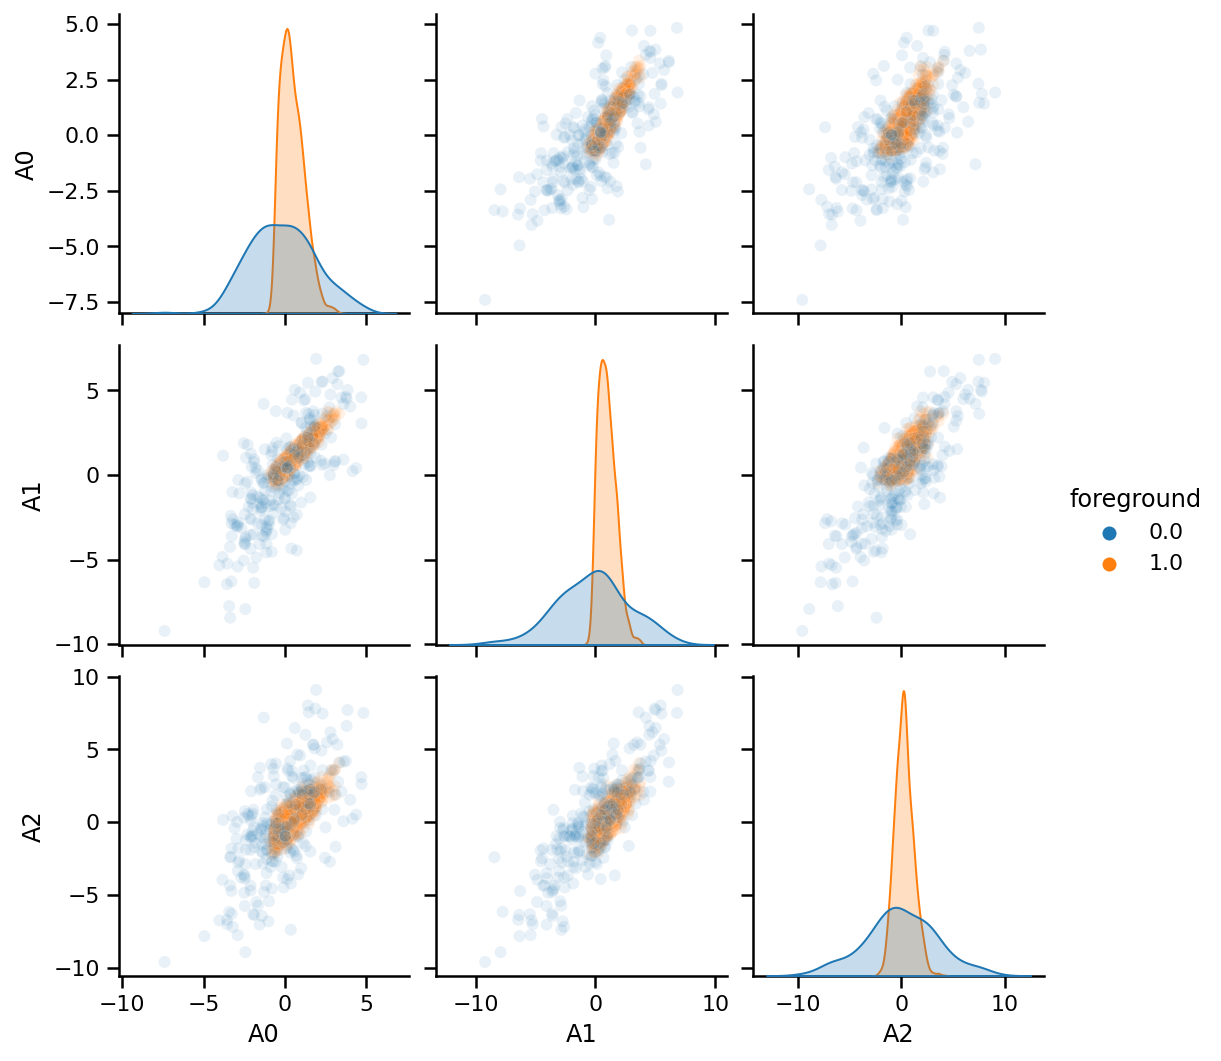

In [4]:
df = pd.DataFrame(Aobs, columns=['A0', 'A1', 'A2'])
df['foreground'] = np.concatenate((np.ones(Nfg), np.zeros(Nbg)))
sns.pairplot(df, hue='foreground', diag_kws={'common_norm': False}, plot_kws={'alpha': 0.1})

Zooming in on the $A_0$ photometry:

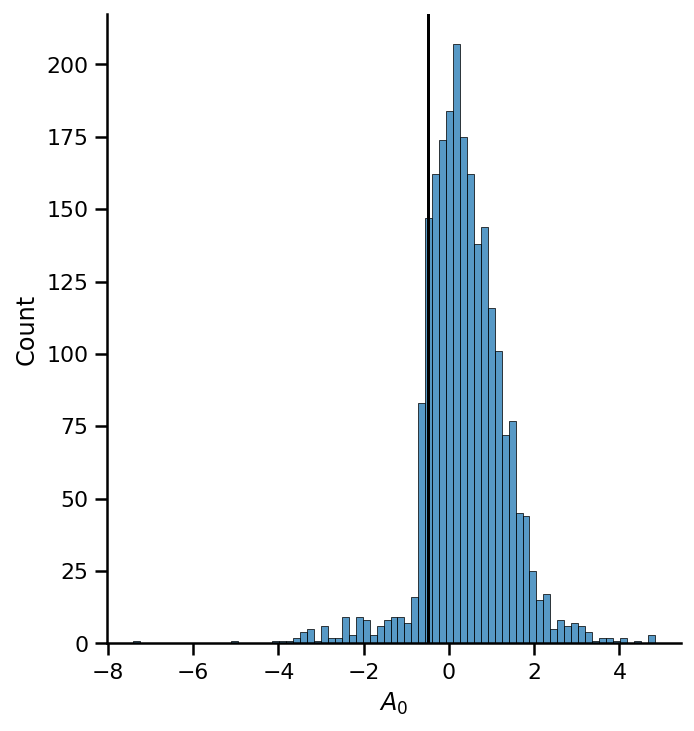

In [5]:
sns.displot(Aobs[:,0])
plt.xlabel(r'$A_0$')
plt.axvline(edge, color='k')

And the "rectified" (i.e. "color corrected") $A_0$ photometry, which shows a bit sharper edge:

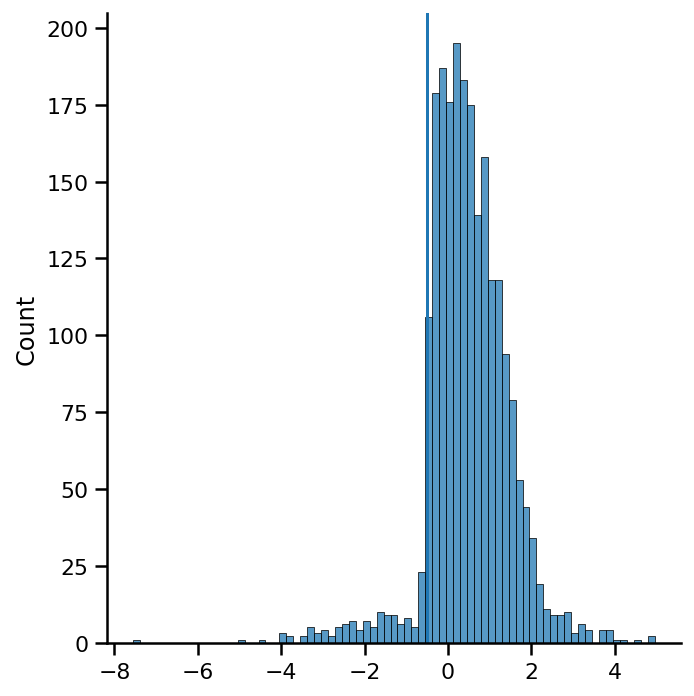

In [6]:
eobs = np.dot(Aobs, w)
sigma_eobs = np.sqrt(np.sum(w[None,:]*w[None,:]*sigma_obs*sigma_obs, axis=1))
mu_e = np.dot(w, mu_fg)
sigma_e = np.sqrt(np.dot(w, np.dot(cov_fg, w)))

sns.displot(eobs)
plt.axvline(edge)

In [9]:
num_chains=4
if num_chains > 1:
    init_params = {k: jnp.array([v for _ in range(num_chains)]) for k,v in init_params.items()}

sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=num_chains)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, e_center_mu=e_mu, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, init_params=init_params)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

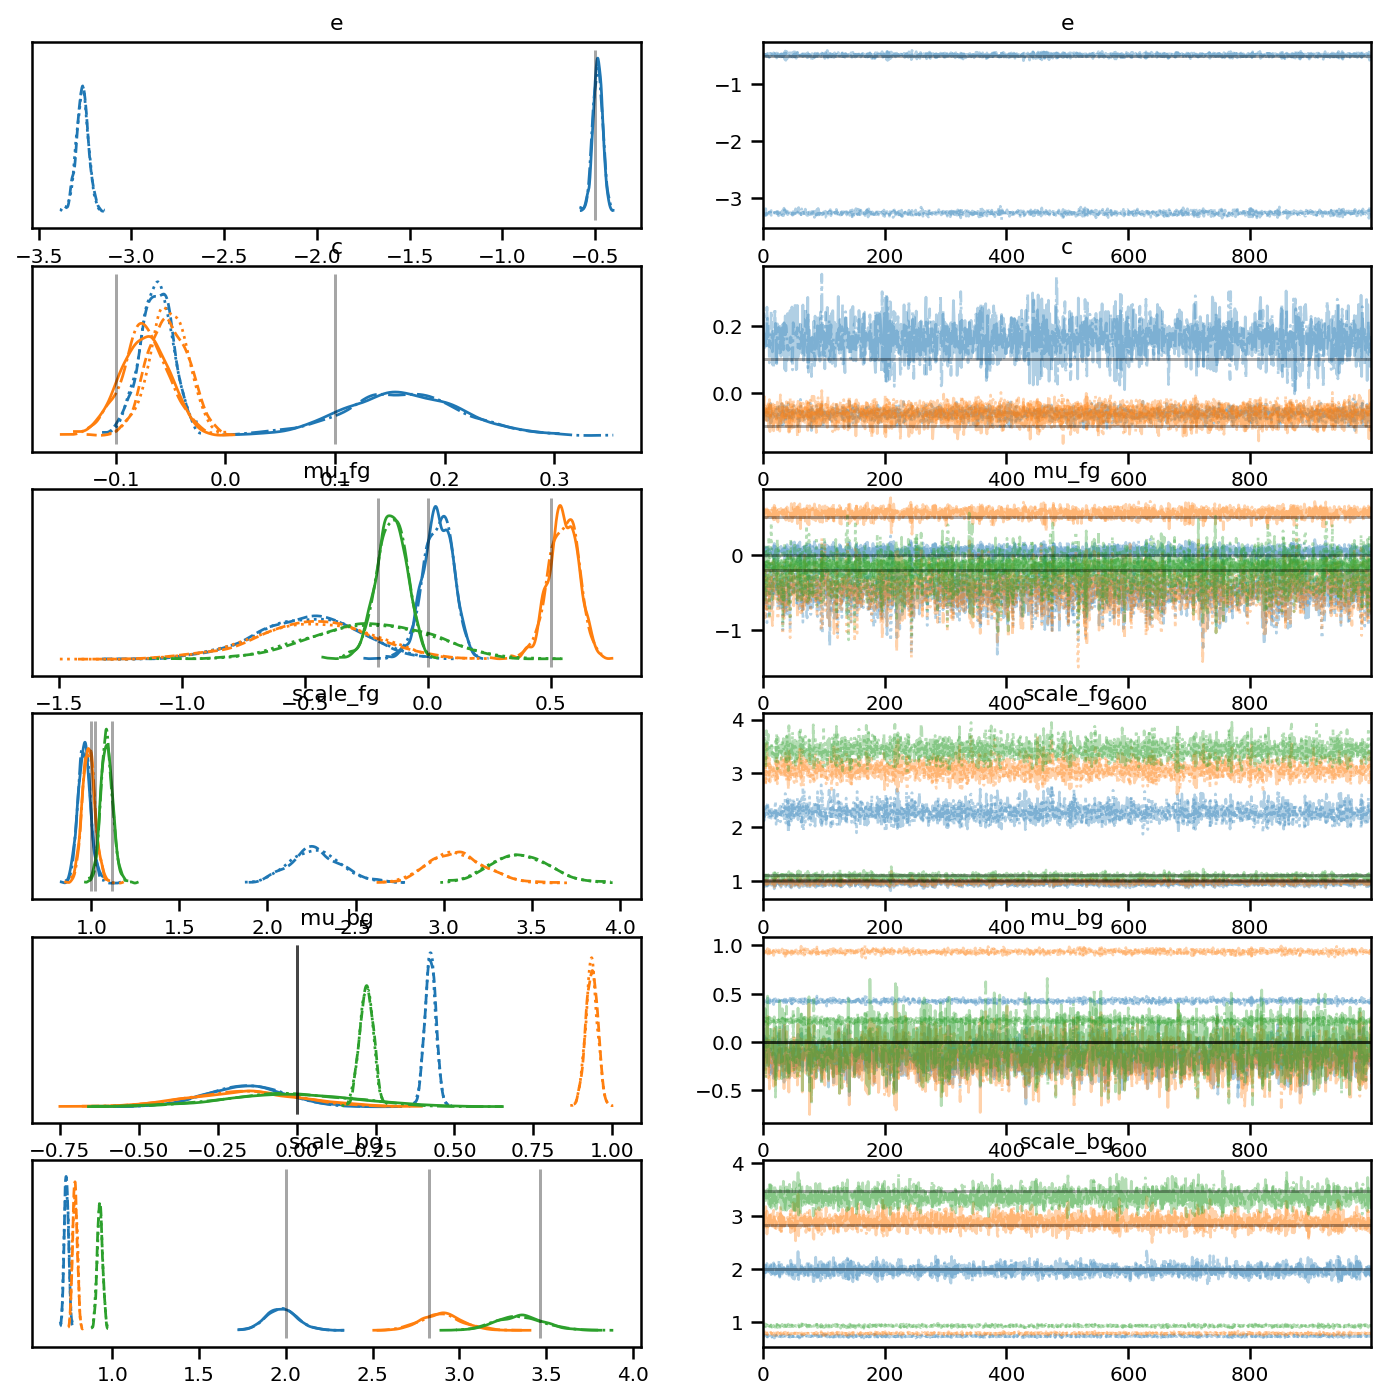

In [12]:
az.plot_trace(trace, var_names=['e', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e', {}, edge), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)])

Looks like initialization is still an issue, so the cell below is set up to exclude some chains that have gone wrong.  Edit the `good_chains` variable to point to the indices of the chains that are OK.

array([[<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

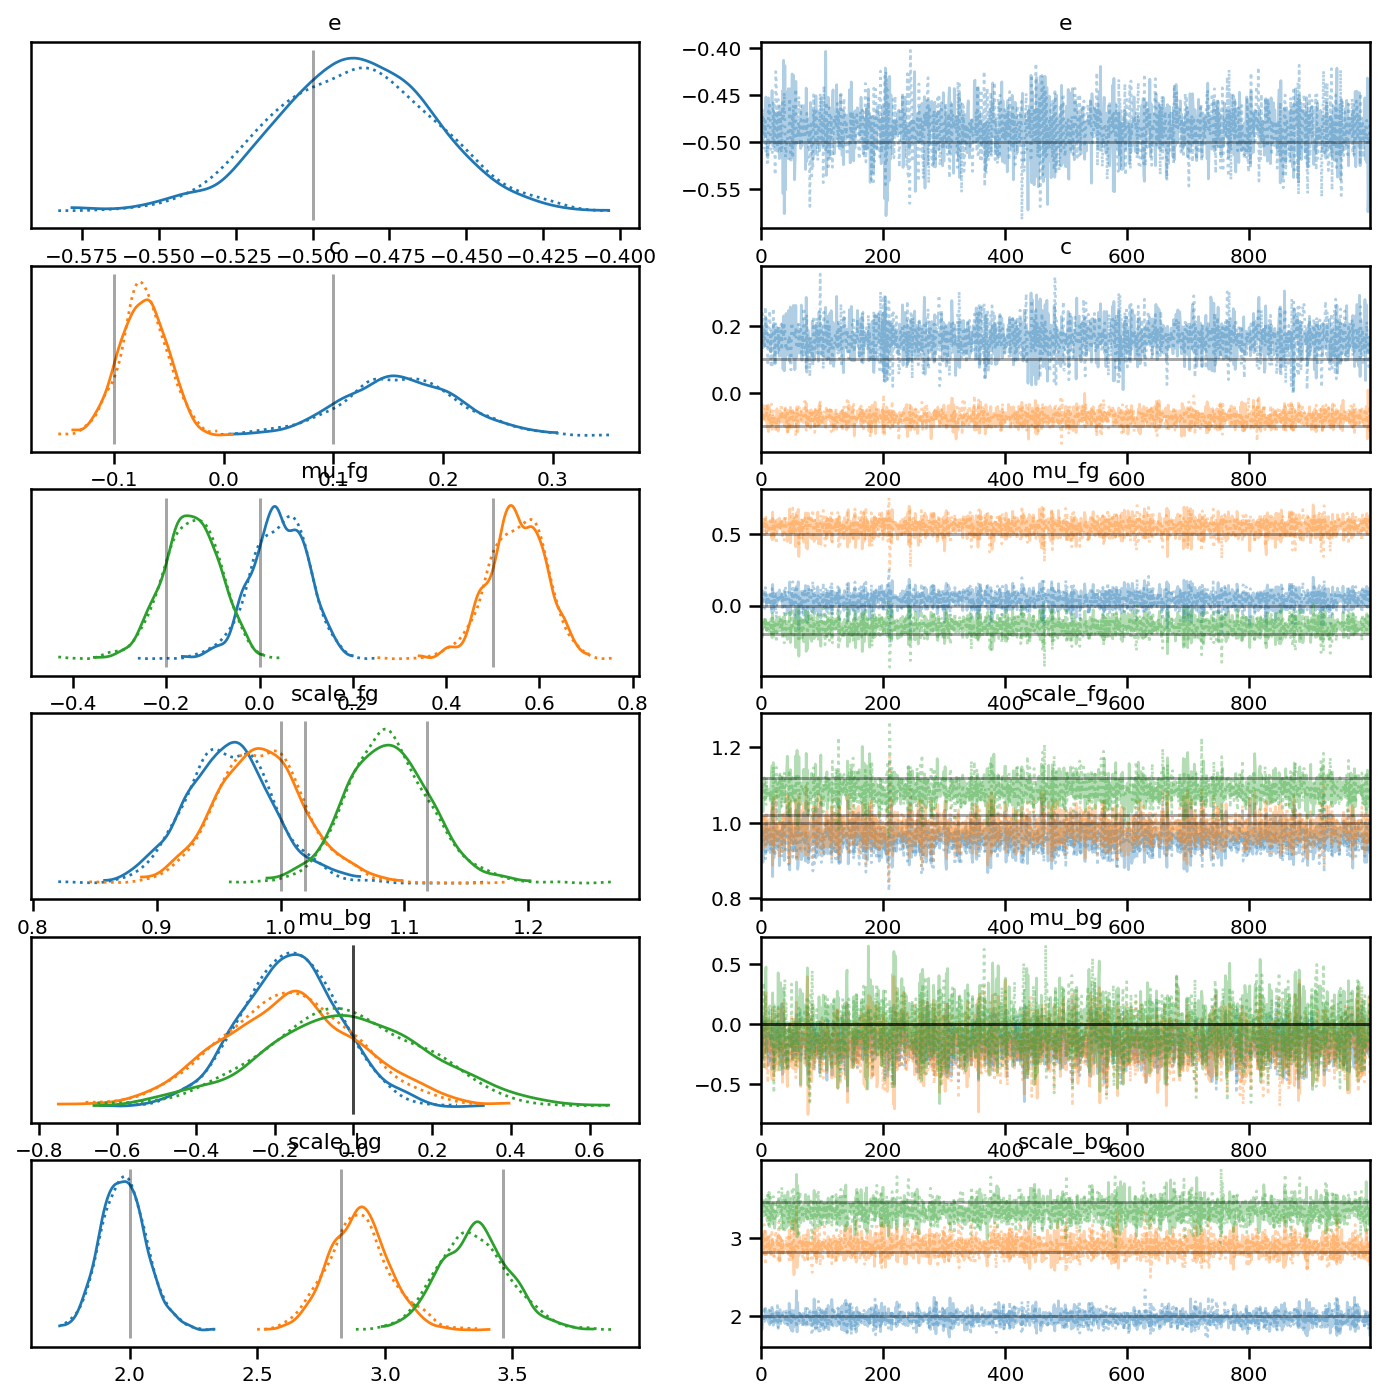

In [15]:
good_chains=[0,3]
az.plot_trace(trace, var_names=['e', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e', {}, edge), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)],
              coords={'chain': good_chains})

In [16]:
trace = az.from_numpyro(mcmc)
az.summary(trace, var_names=['e', 'c','mu_fg', 'cov_fg', 'mu_bg', 'cov_bg'], coords={'chain': good_chains})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e,-0.487,0.026,-0.536,-0.436,0.000,0.000,3240.0,1388.0,1.0
c[0],0.161,0.053,0.065,0.267,0.001,0.001,3491.0,997.0,1.0
c[1],-0.073,0.022,-0.112,-0.031,0.000,0.000,2834.0,1649.0,1.0
mu_fg[0],0.041,0.061,-0.066,0.158,0.001,0.001,3108.0,1294.0,1.0
mu_fg[1],0.551,0.061,0.444,0.666,0.001,0.001,3062.0,1352.0,1.0
mu_fg[2],-0.148,0.061,-0.256,-0.036,0.001,0.001,3137.0,1459.0,1.0
"cov_fg[0, 0]",0.921,0.068,0.800,1.056,0.001,0.001,3106.0,1584.0,1.0
"cov_fg[0, 1]",0.926,0.069,0.805,1.064,0.001,0.001,3132.0,1520.0,1.0
"cov_fg[0, 2]",0.924,0.069,0.794,1.050,0.001,0.001,2897.0,1615.0,1.0
"cov_fg[1, 0]",0.926,0.069,0.805,1.064,0.001,0.001,3132.0,1520.0,1.0


Text(0.5, 0, '$A_1 - A_0$')

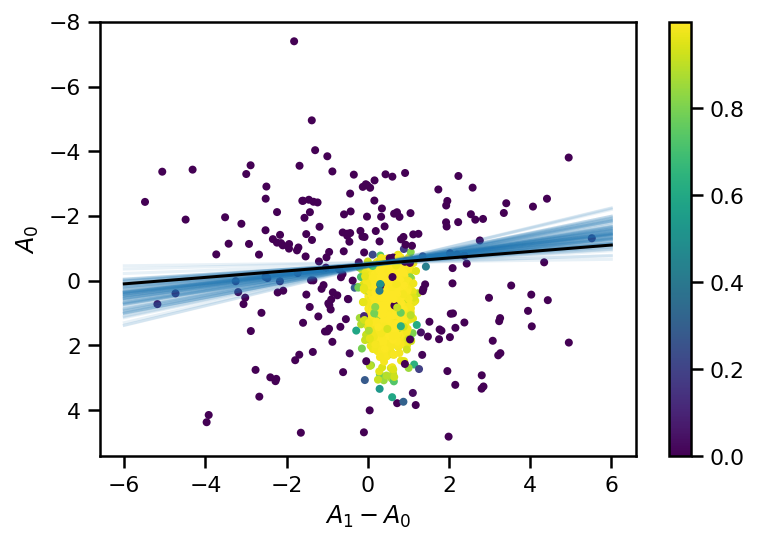

In [21]:
plt.scatter(Aobs[:,1]-Aobs[:,0], Aobs[:,0], c=np.exp(trace.posterior.log_fg_prob[good_chains,:,:].mean(axis=(0,1))), marker='.')
yl, yh = plt.ylim()
plt.ylim(yh, yl)
plt.colorbar()

cs = np.linspace(-6, 6, 1024)
for _ in range(100):
    c = np.random.choice(good_chains)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(cs, trace.posterior.e[c,d].values - trace.posterior.c[c,d,0].values*cs, color=sns.color_palette()[0], alpha=0.1)
plt.plot(cs, edge - c_mu[0]*cs, color='k')
plt.ylabel(r'$A_0$')
plt.xlabel(r'$A_1 - A_0$')